In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

plt.rcParams["figure.figsize"] = (20,6)

### Criando as funções

In [3]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [10]:
def apl_model (df_st,n_lags):

    print('Janela Analisada: ', n_lags,'dias\n')

    X = get_lags(df_st, n_lags)
    y = df_st.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'splitter': ['best', 'random'],
             'max_depth': range(1,50)
             }

    dtr = DecisionTreeRegressor()
    dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'criterion': [res.best_params_['criterion']],
             'splitter': [res.best_params_['splitter']],
             'max_depth': [res.best_params_['max_depth']]}
    
    dtr_GS = AdaBoostRegressor(DecisionTreeRegressor(max_depth = res.best_params_['max_depth'], 
                                                  criterion = res.best_params_['criterion'],
                                                  splitter = res.best_params_['splitter']),
                            n_estimators=500)

    #dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)
    #print( res.best_score_, res.best_params_)

    r2 = r2_score(dtr_GS.predict(X_test),y_test)
    mse = mean_squared_error(dtr_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(dtr_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(dtr_GS.predict(X_test),y_test)

    print('SVR model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)


    #plot previsão com teste
    fig, ax = plt.subplots()
    ax.plot(dtr_GS.predict(X_test).flatten(), label='pred')
    ax.plot(y_test.reset_index(drop=True), label='true')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show()

   #plot de total com previsão
    previsao = pd.DataFrame(dtr_GS.predict(X_test).flatten(), index = X_test.index)
    concat = pd.concat([y_train, previsao],axis=1)

    concat.plot(linewidth=2, figsize=(20,7), color=['y','b'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Real x Previsto',size=15)
    plt.show();

    fig, ax = plt.subplots()
    ax.plot(df_st, label='Real', color = 'y')
    ax.plot(previsao, label='Previsões', linewidth=2, color='b')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();

    
    return r2, mse, rmse, mae, mape

In [5]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30, 45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse, mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse, mae, mape]
        results.append(result)

    return results

### Lendo dataset

In [6]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_13492\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicando o Modelo

Janela Analisada:  7 dias

########################################
Melhor Score:  0.2727533348597717
Melhores Parametros:  {'criterion': 'absolute_error', 'max_depth': 2, 'splitter': 'best'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 





C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR model Results
r2 -8.09536398238905
mse 1955513.7765306123
rmse 1398.3968594539292
mae 647.6346938775511
mape 0.5451377456834215


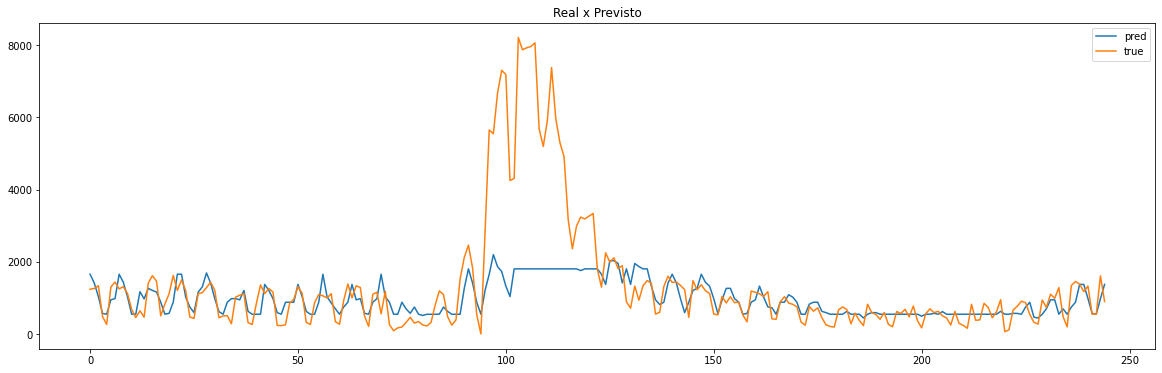

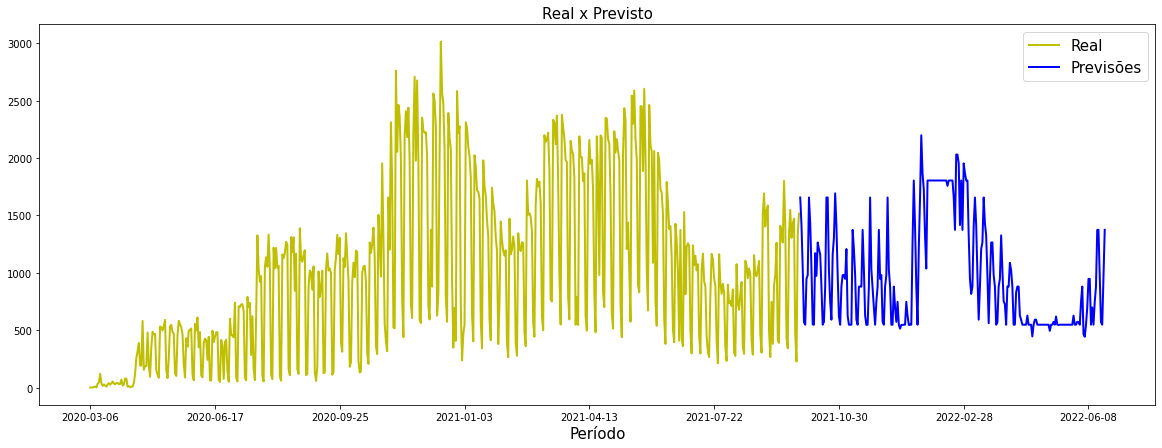

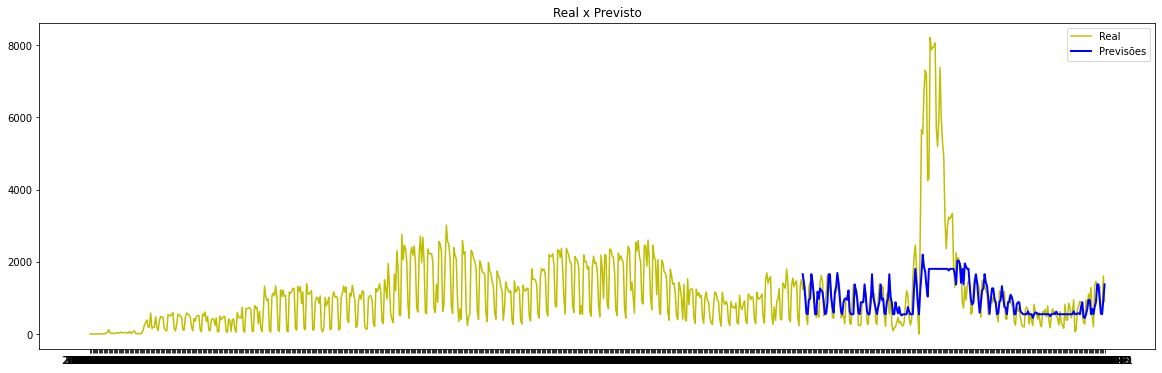

Janela Analisada:  15 dias

########################################
Melhor Score:  0.308938700828672
Melhores Parametros:  {'criterion': 'absolute_error', 'max_depth': 4, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 





C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR model Results
r2 -6.985570991813001
mse 1860413.3357438017
rmse 1363.9696975167012
mae 611.8615702479339
mape 0.49754832212116795


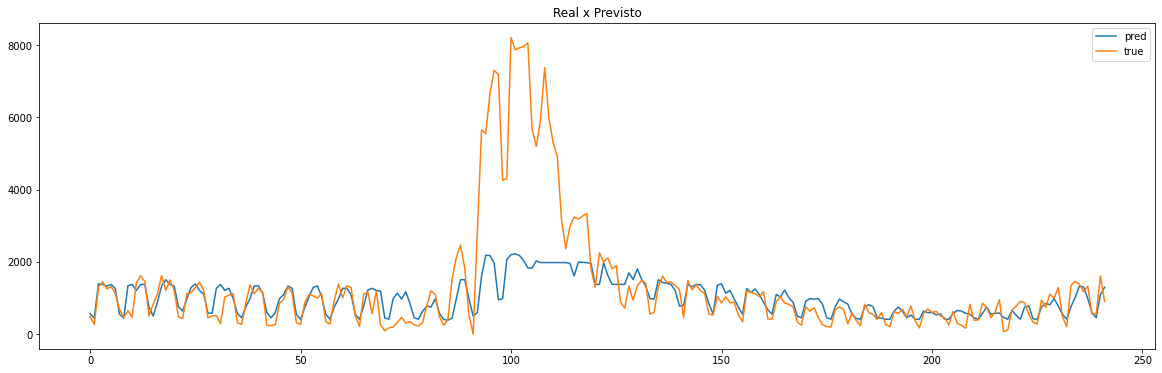

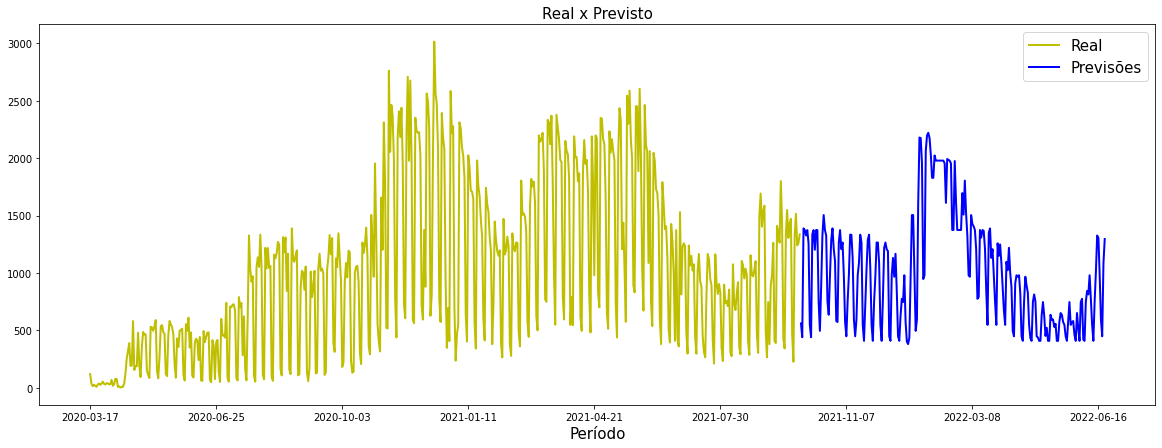

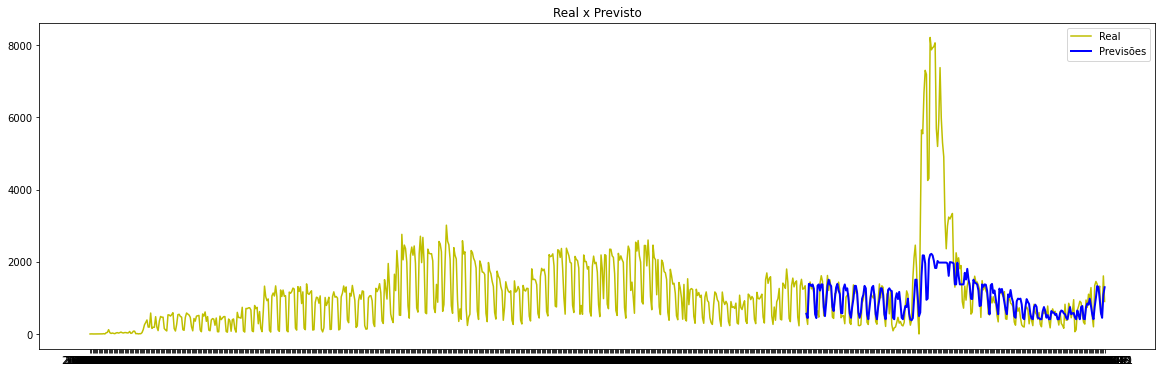

Janela Analisada:  30 dias

########################################
Melhor Score:  0.236489274356608
Melhores Parametros:  {'criterion': 'absolute_error', 'max_depth': 4, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 





C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR model Results
r2 -7.983992823007577
mse 1925089.0766806724
rmse 1387.4757931872803
mae 639.8550420168067
mape 0.5173095685419989


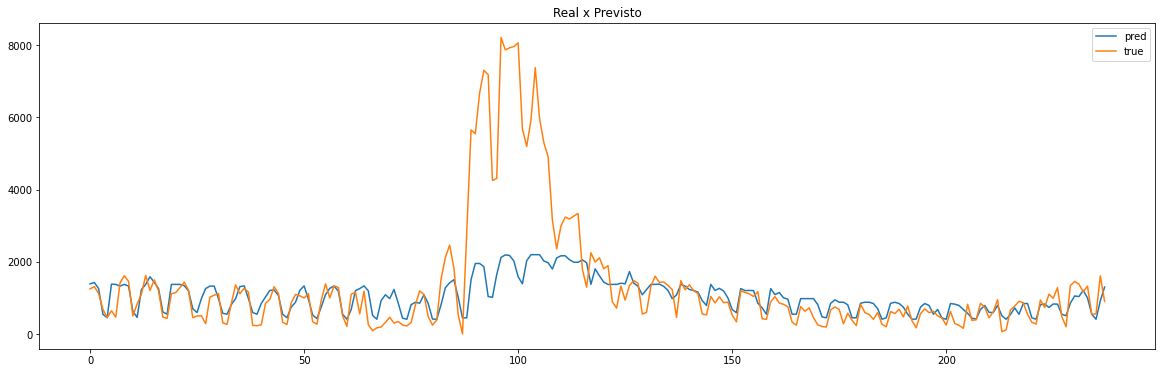

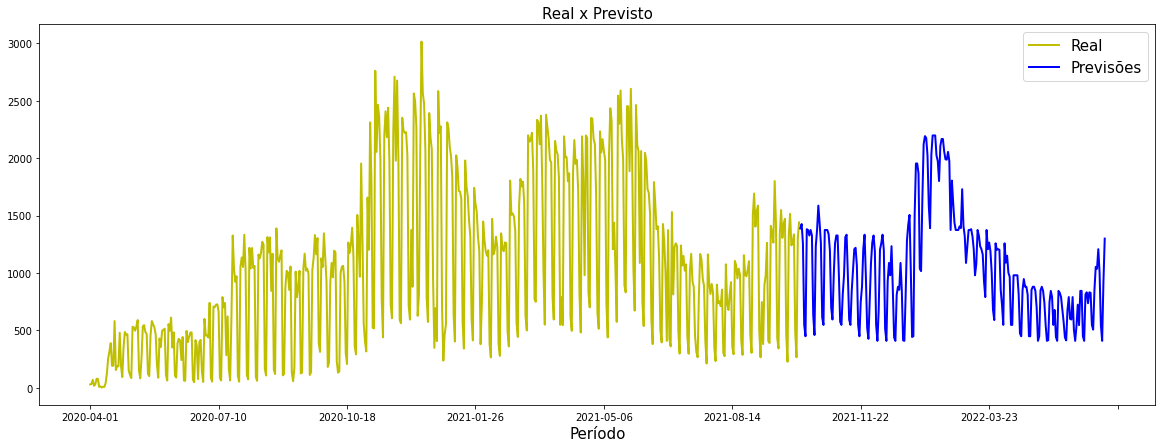

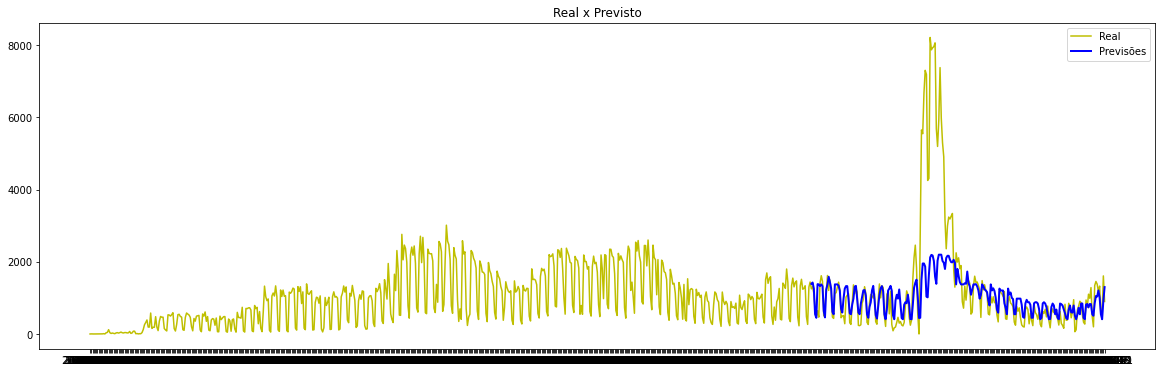

Janela Analisada:  45 dias

########################################
Melhor Score:  0.2865940316016997
Melhores Parametros:  {'criterion': 'friedman_mse', 'max_depth': 4, 'splitter': 'best'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 





C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR model Results
r2 -7.117410736335563
mse 1952837.2487900816
rmse 1397.4395331426979
mae 650.3201215254871
mape 0.5333478383880388


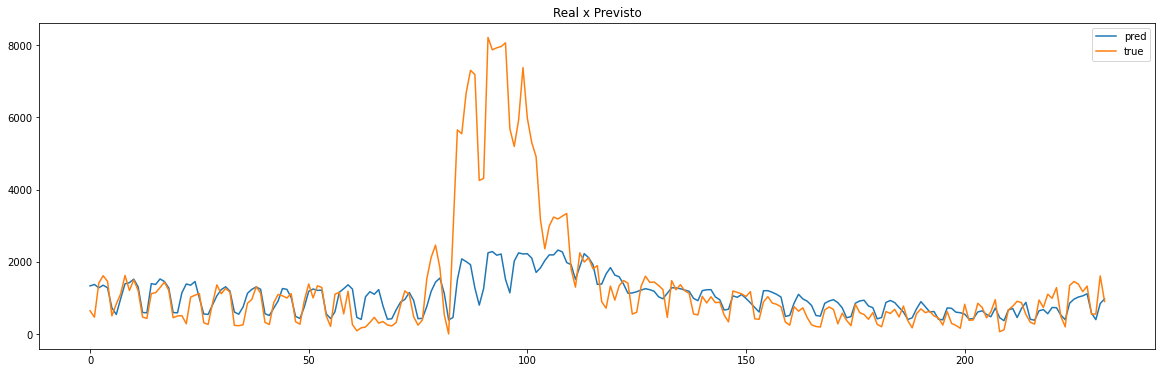

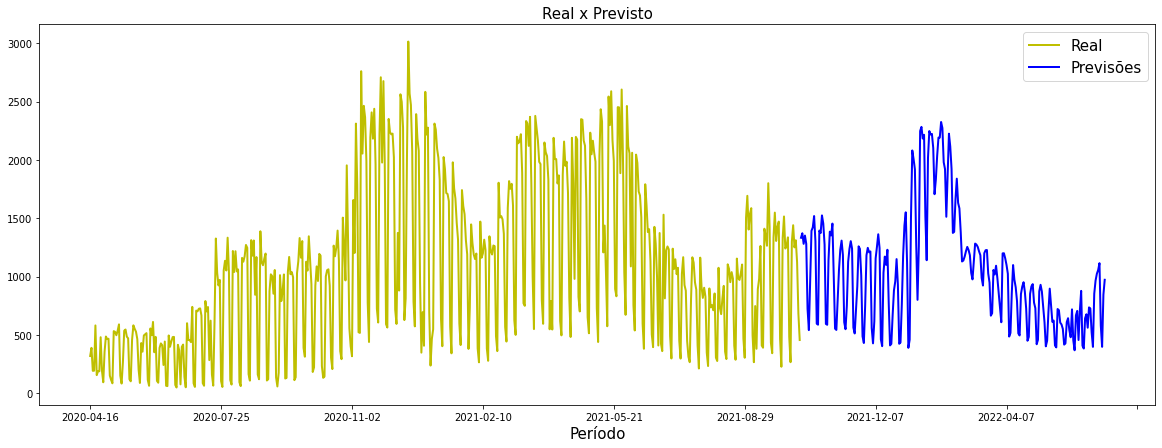

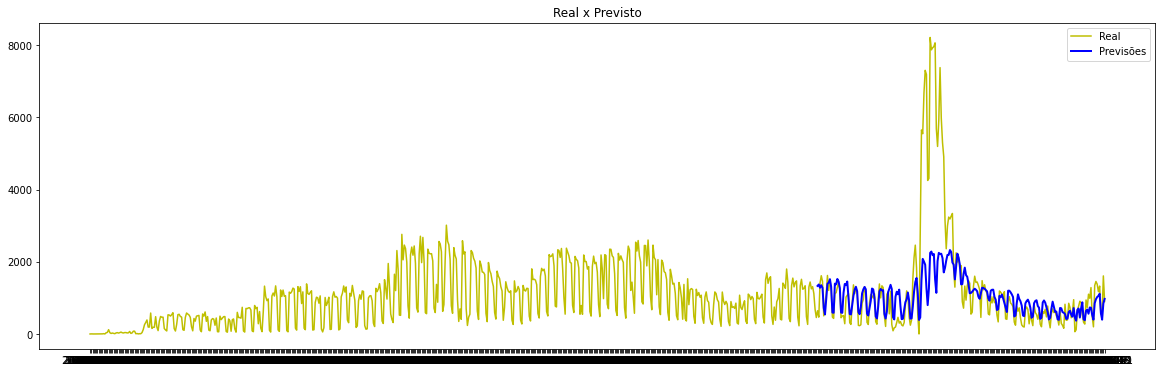

Janela Analisada:  60 dias

########################################
Melhor Score:  0.4394171763189668
Melhores Parametros:  {'criterion': 'friedman_mse', 'max_depth': 5, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 





C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR model Results
r2 -8.514440800436667
mse 1959608.8010668503
rmse 1399.860279123188
mae 666.0512337397734
mape 0.5247980446254527


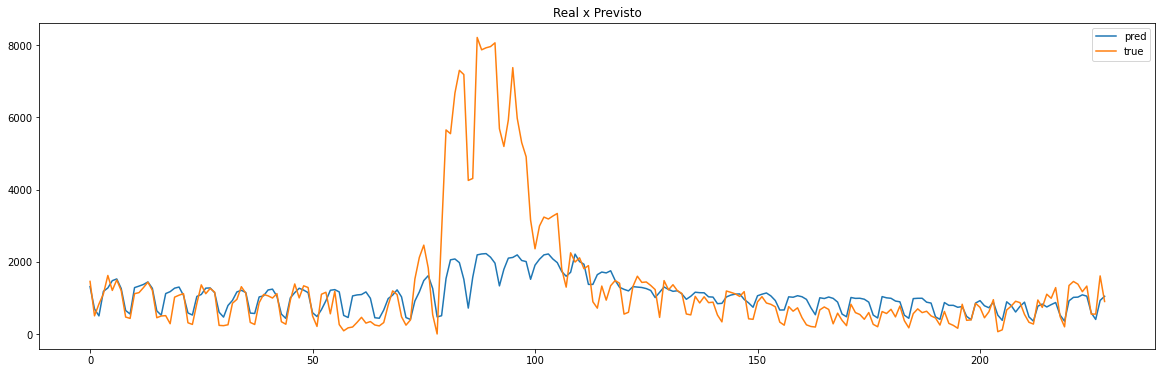

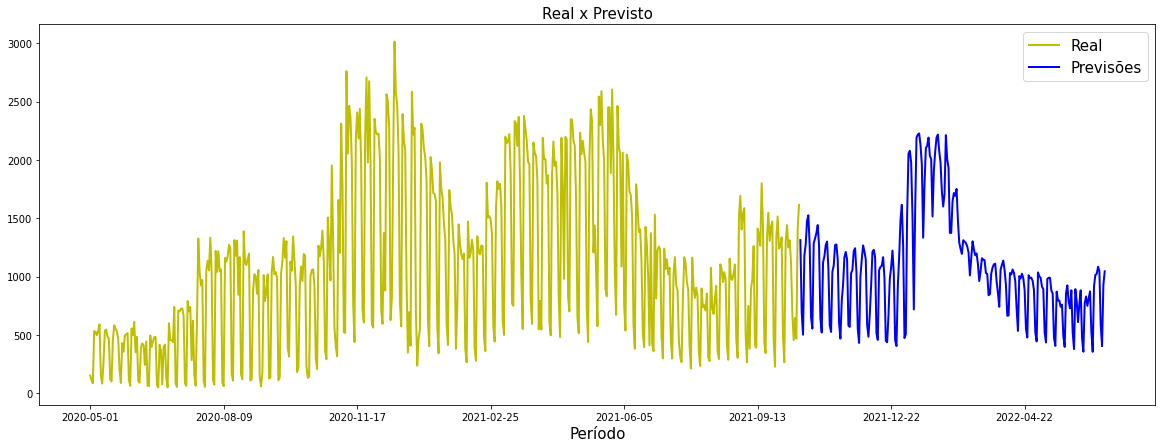

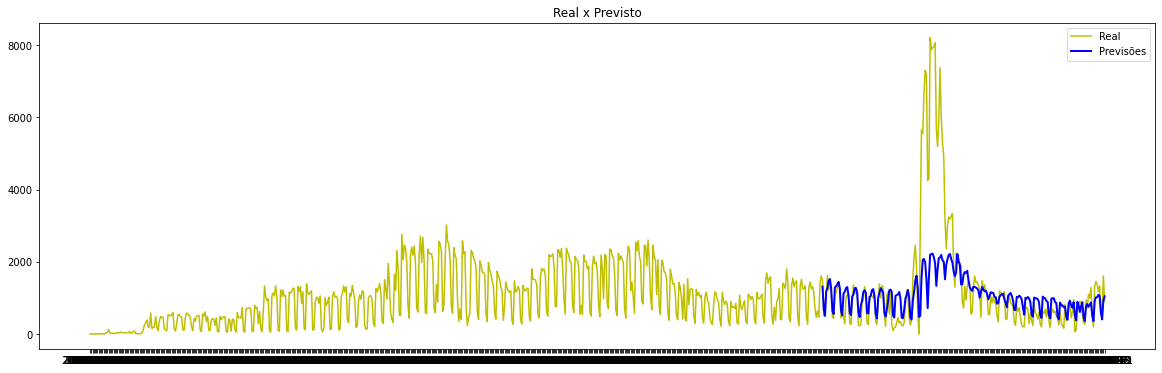

In [11]:
results = apl_for_lags (df_st)

### Resultados

In [12]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results.sort_values(by='R2' , ascending = False)

,R2,MSE,RMSE,MAE,MAPE
15 dias,-6.985571,1.860413e+06,1363.969698,611.861570,0.497548
45 dias,-7.117411,1.952837e+06,1397.439533,650.320122,0.533348
30 dias,-7.983993,1.925089e+06,1387.475793,639.855042,0.517310
7 dias,-8.095364,1.955514e+06,1398.396859,647.634694,0.545138
60 dias,-8.514441,1.959609e+06,1399.860279,666.051234,0.524798
